In [1]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from evaluation import calculate_feature_correlation, select_top_features
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Reading the CSV file containing fraudulent data and storing it in the variable 'fraud'
fraud = pd.read_csv('datasets/PFE_DATASET_FRAUD.csv', delimiter=";")
# Reading the CSV file containing non-fraudulent data and storing it in the variable 'not_fraud'
not_fraud = pd.read_csv('datasets/PFE_DATASET_NOT_FRAUD.csv', delimiter=";")

# Adding a new column 'is_fraud' to the 'fraud' DataFrame and assigning all values as 1
fraud["is_fraud"] = 1
# Adding a new column 'is_fraud' to the 'not_fraud' DataFrame and assigning all values as 0
not_fraud["is_fraud"] = 0

# Concatenating the 'fraud' and 'not_fraud' DataFrames along rows to create a single DataFrame 'df'
df = pd.concat([fraud, not_fraud])

# Converting the 'Charging_Tm' column to datetime format in the 'df' DataFrame
df['Charging_Tm'] = pd.to_datetime(df['Charging_Tm'])

In [3]:
# Filtering the DataFrame 'df' to select rows where the 'Charging_Tm' column is greater than April 22, 2024, and less than April 25, 2024
df = df[(df["Charging_Tm"] > pd.to_datetime("22/04/2024")) & (df["Charging_Tm"] < pd.to_datetime("25/04/2024"))]

# Grouping the DataFrame 'df' by the column 'A_Num', and then checking if any transaction within each group is flagged as fraud
Counter(df.groupby("A_Num")["is_fraud"].any().astype(int).reset_index()["is_fraud"])

C:\Users\tr3h2\AppData\Local\Temp\ipykernel_6376\4210081689.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = df[(df["Charging_Tm"] > pd.to_datetime("22/04/2024")) & (df["Charging_Tm"] < pd.to_datetime("25/04/2024"))]


Counter({0: 14634, 1: 660})

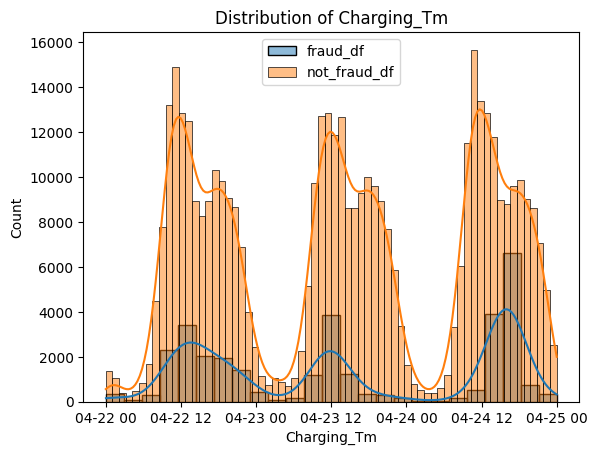

In [4]:
# Creating a new figure
plt.figure()

# Plotting histogram for "Charging_Tm" in fraud_df with fill and kernel density estimate
sns.histplot(df[df["is_fraud"]==1]["Charging_Tm"], label='fraud_df', fill=True, kde=True)

# Plotting histogram for "Charging_Tm" in not_fraud_df with fill and kernel density estimate
sns.histplot(df[df["is_fraud"]==0]["Charging_Tm"], label='not_fraud_df', fill=True, kde=True)

# Setting title for the plot
plt.title(f'Distribution of {"Charging_Tm"}')
plt.legend()
plt.show()

In [5]:
# Grouping the DataFrame by "A_Num" and checking if there is any fraud ('is_fraud') for each group.
# Converting the boolean result to integers (1 for True, 0 for False).
features_df = df.groupby("A_Num")["is_fraud"].any().astype(int).reset_index()
features_df.columns = ['A_Num', 'is_fraud']

# Calculating the mean and standard deviation of the time differences between consecutive "Charging_Tm" values for each "A_Num" group.
features_df[['AVG_CALL_FREQ', 'STD_CALL_FREQ']] = df.sort_values(['A_Num', 'Charging_Tm']).groupby('A_Num')['Charging_Tm'].diff().dt.total_seconds().groupby(df.sort_values(['A_Num', 'Charging_Tm'])['A_Num']).agg(['mean', 'std'])

# Creating features related to destination categories ("ON-NET", "OFF-NET", "INTERNATIONAL"):
for des in ["ON-NET", "OFF-NET", "INTERNATIONAL"]:
   features_df[des.replace('-', '_')+'_RATIO'] = df.groupby('A_Num').agg(ON_NET_RATIO=('DESTINATION_CAT', lambda x: (x==des).sum() / len(x)))
# Creating features related to call types (0, 1, 6, 7):
for call_type in [0, 1, 6, 7]:
    features_df['CALLTYPE_'+str(call_type)+'_RATIO'] = df.groupby('A_Num').agg(TELESRVC11_RATIO=('Call_Type', lambda x: (x==call_type).sum() / len(x)))

# Creating features related to call frequency:
features_df['MIN_CALL_FREQ'] = df.groupby('A_Num').apply(lambda x: x.sort_values('Charging_Tm')).reset_index(drop=True).assign(INTERVAL_ACTIVITIES_SECONDS=lambda x: x.groupby('A_Num')['Charging_Tm'].diff().dt.total_seconds()).groupby('A_Num')['INTERVAL_ACTIVITIES_SECONDS'].min()
features_df['AVG_CALL_FREQ'] = df.groupby('A_Num').apply(lambda x: x.sort_values('Charging_Tm')).reset_index(drop=True).assign(INTERVAL_ACTIVITIES_SECONDS=lambda x: x.groupby('A_Num')['Charging_Tm'].diff().dt.total_seconds()).groupby('A_Num')['INTERVAL_ACTIVITIES_SECONDS'].mean()
features_df['MAX_CALL_FREQ'] = df.groupby('A_Num').apply(lambda x: x.sort_values('Charging_Tm')).reset_index(drop=True).assign(INTERVAL_ACTIVITIES_SECONDS=lambda x: x.groupby('A_Num')['Charging_Tm'].diff().dt.total_seconds()).groupby('A_Num')['INTERVAL_ACTIVITIES_SECONDS'].max()

# Creating features related to daily call counts and durations:
features_df['MIN_DAILY_CALLS'] = df.groupby(['A_Num', df['Charging_Tm'].dt.date])['A_Num'].count().groupby('A_Num').min()
features_df['AVG_DAILY_CALLS'] = df.groupby(['A_Num', df['Charging_Tm'].dt.date])['A_Num'].count().groupby('A_Num').mean()
features_df['MAX_DAILY_CALLS'] = df.groupby(['A_Num', df['Charging_Tm'].dt.date])['A_Num'].count().groupby('A_Num').max()
features_df['MIN_DAILY_CALLS_DUR'] = df.groupby(['A_Num', df['Charging_Tm'].dt.date])['Call_Duration'].sum().groupby('A_Num').min()
features_df['AVG_DAILY_CALLS_DUR'] = df.groupby(['A_Num', df['Charging_Tm'].dt.date])['Call_Duration'].sum().groupby('A_Num').mean()
features_df['MAX_DAILY_CALLS_DUR'] = df.groupby(['A_Num', df['Charging_Tm'].dt.date])['Call_Duration'].sum().groupby('A_Num').max()

# Displaying the first few rows of the resulting features DataFrame features_df.
features_df.head()

C:\Users\tr3h2\AppData\Local\Temp\ipykernel_6376\169805568.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df['MIN_CALL_FREQ'] = df.groupby('A_Num').apply(lambda x: x.sort_values('Charging_Tm')).reset_index(drop=True).assign(INTERVAL_ACTIVITIES_SECONDS=lambda x: x.groupby('A_Num')['Charging_Tm'].diff().dt.total_seconds()).groupby('A_Num')['INTERVAL_ACTIVITIES_SECONDS'].min()
C:\Users\tr3h2\AppData\Local\Temp\ipykernel_6376\169805568.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the

,A_Num,is_fraud,AVG_CALL_FREQ,STD_CALL_FREQ,ON_NET_RATIO,OFF_NET_RATIO,INTERNATIONAL_RATIO,CALLTYPE_0_RATIO,CALLTYPE_1_RATIO,CALLTYPE_6_RATIO,CALLTYPE_7_RATIO,MIN_CALL_FREQ,MAX_CALL_FREQ,MIN_DAILY_CALLS,AVG_DAILY_CALLS,MAX_DAILY_CALLS,MIN_DAILY_CALLS_DUR,AVG_DAILY_CALLS_DUR,MAX_DAILY_CALLS_DUR
0,0,0,3979.555556,8419.112096,0.750000,0.140625,0.078125,0.546875,0.312500,0.031250,0.109375,1.0,47254.0,15.0,21.333333,29.0,1460.247264,1630.493556,1747.974064
1,1,0,14883.083333,26051.316116,0.769231,0.000000,0.230769,0.538462,0.230769,0.000000,0.230769,1.0,81057.0,1.0,4.333333,7.0,645.005592,1059.039956,1634.591832
2,2,0,6314.352941,10738.082716,0.600000,0.314286,0.085714,0.742857,0.142857,0.000000,0.114286,6.0,47547.0,10.0,11.666667,13.0,764.170848,1646.390595,2592.317196
3,3,0,5845.451613,9580.281408,0.218750,0.687500,0.093750,0.531250,0.312500,0.062500,0.093750,1.0,37634.0,3.0,10.666667,17.0,614.121108,811.008957,1107.697252
4,4,0,8679.269231,18837.281542,0.592593,0.222222,0.000000,0.518519,0.222222,0.074074,0.185185,2.0,84642.0,4.0,9.000000,17.0,243.059292,1429.920959,3348.735656


In [6]:
# Filling missing values in the features DataFrame features_df with zeros
features_df = features_df.fillna(0)

In [7]:
# Getting the names of all columns in the DataFrame features_df except for 'A_Num' and 'is_fraud'
features = features_df.columns.difference(['A_Num', 'is_fraud'])

features

Index(['AVG_CALL_FREQ', 'AVG_DAILY_CALLS', 'AVG_DAILY_CALLS_DUR',
       'CALLTYPE_0_RATIO', 'CALLTYPE_1_RATIO', 'CALLTYPE_6_RATIO',
       'CALLTYPE_7_RATIO', 'INTERNATIONAL_RATIO', 'MAX_CALL_FREQ',
       'MAX_DAILY_CALLS', 'MAX_DAILY_CALLS_DUR', 'MIN_CALL_FREQ',
       'MIN_DAILY_CALLS', 'MIN_DAILY_CALLS_DUR', 'OFF_NET_RATIO',
       'ON_NET_RATIO', 'STD_CALL_FREQ'],
      dtype='object')

In [8]:
from sklearn.preprocessing import PowerTransformer

# Extracting features for fraudulent and non-fraudulent data
fraud_features = features_df[features_df['is_fraud'] == 1][features]
not_fraud_features = features_df[features_df['is_fraud'] == 0][features]

# Initializing PowerTransformer with 'yeo-johnson' method for handling both positive and negative values
# Setting standardize=True to center and scale the data
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Fitting and transforming the features for fraudulent and non-fraudulent data separately
fraud_transformed = pt.fit_transform(fraud_features)
not_fraud_transformed = pt.fit_transform(not_fraud_features)

# Creating DataFrames from the transformed features with column names
fraud_transformed_df = pd.DataFrame(fraud_transformed, columns=features)
fraud_transformed_df["is_fraud"] = 1  # Adding 'is_fraud' column indicating fraud

not_fraud_transformed_df = pd.DataFrame(not_fraud_transformed, columns=features)
not_fraud_transformed_df["is_fraud"] = 0  # Adding 'is_fraud' column indicating non-fraud

# Concatenating the transformed data for fraudulent and non-fraudulent data
transformed_df = pd.concat([fraud_transformed_df, not_fraud_transformed_df])

In [9]:
# Exporting the DataFrame transformed_df to a CSV file named "final_features_dataset.csv"
# The file will be saved in the "datasets" directory
transformed_df.to_csv("datasets/final_features_dataset.csv")

In [10]:
transformed_df.head()

,AVG_CALL_FREQ,AVG_DAILY_CALLS,AVG_DAILY_CALLS_DUR,CALLTYPE_0_RATIO,CALLTYPE_1_RATIO,CALLTYPE_6_RATIO,CALLTYPE_7_RATIO,INTERNATIONAL_RATIO,MAX_CALL_FREQ,MAX_DAILY_CALLS,MAX_DAILY_CALLS_DUR,MIN_CALL_FREQ,MIN_DAILY_CALLS,MIN_DAILY_CALLS_DUR,OFF_NET_RATIO,ON_NET_RATIO,STD_CALL_FREQ,is_fraud
0,-0.746836,1.495831,1.064685,1.429191,0.684298,-0.409561,-1.348107,-1.148538,0.457183,1.363927,0.909417,0.842760,1.607900,1.360236,1.190674,0.978842,-0.115577,1
1,0.348697,-0.292812,0.016972,0.221305,-0.362834,-0.409561,0.897726,1.500838,0.198770,-0.117580,0.080546,-0.687614,-0.846379,-1.044646,0.177132,-0.446193,0.493554,1
2,-0.047172,0.455997,-0.577323,-0.869799,-0.702098,-0.409561,1.276147,0.059762,0.472258,0.464907,-0.674156,-0.687614,-0.301845,-0.135774,0.033301,-1.157375,0.181621,1
3,1.942725,-0.932511,-1.256902,-0.869799,-1.207388,-0.409561,1.405638,1.730956,1.733026,-0.919473,-1.260315,1.717803,-0.846379,-1.044646,-0.994032,-1.157375,2.167931,1
4,-0.187578,0.675504,0.683496,1.552247,0.248301,-0.409561,-1.348107,-1.148538,0.278999,0.716448,0.562708,0.812649,0.647374,1.104151,1.663967,0.095572,0.102663,1


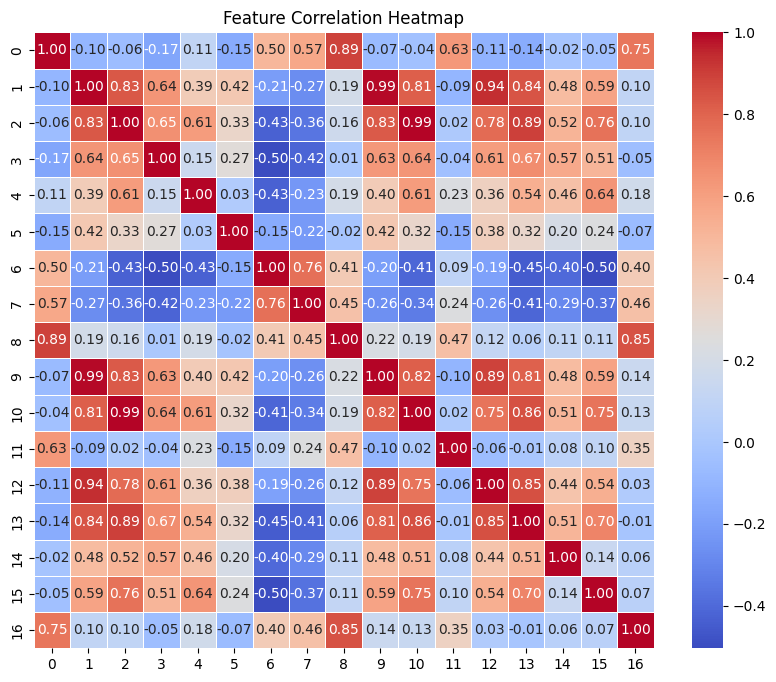

In [11]:

calculate_feature_correlation.calculate_feature_correlation(transformed_df.drop(columns=['is_fraud']), range(len(transformed_df.columns.difference(['is_fraud']))))

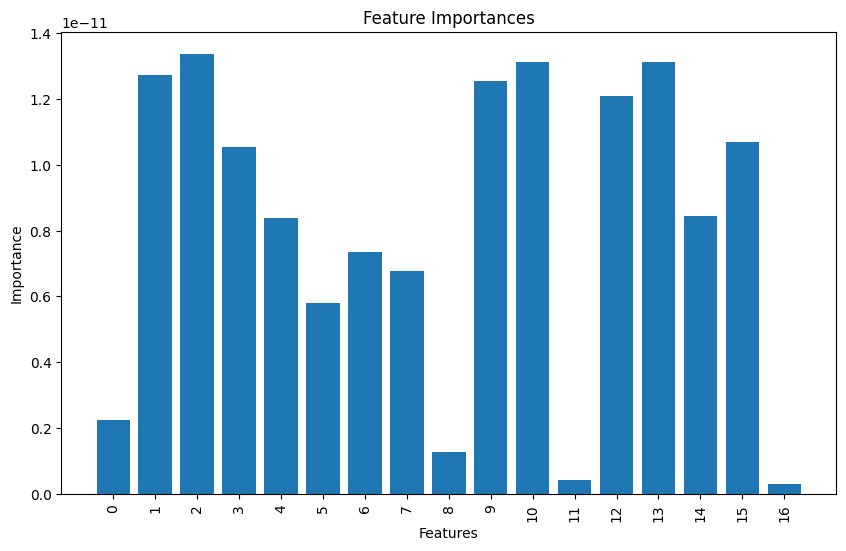

[2, 13, 10, 1, 9, 12, 15, 3, 14, 4]

In [12]:
model = LogisticRegression()
select_top_features.select_top_features(transformed_df.drop(columns=['is_fraud']), transformed_df['is_fraud'], model, 10)

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from evaluation import full_evaluate

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_feature_for_classification(df, feature):
    """
    Generates various plots to evaluate if a feature is good for classification.

    Parameters:
    df (pd.DataFrame): The dataset containing the feature and the target label 'is_fraud'.
    feature (str): The name of the feature to evaluate.
    """
    # Check if the feature exists in the dataframe
    if feature not in df.columns or 'is_fraud' not in df.columns:
        print(f"The feature '{feature}' or 'is_fraud' label is not in the dataframe.")
        return

    # Set the style of seaborn
    sns.set(style="whitegrid")
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Histogram for feature distribution
    sns.histplot(data=df, x=feature, hue='is_fraud', multiple='stack', ax=axs[0, 0], kde=True)
    axs[0, 0].set_title(f'{feature} Distribution by is_fraud')
    
    # Boxplot to show distribution
    sns.boxplot(x='is_fraud', y=feature, data=df, ax=axs[0, 1])
    axs[0, 1].set_title(f'{feature} Boxplot by is_fraud')
    
    # Violin plot to show distribution
    sns.violinplot(x='is_fraud', y=feature, data=df, ax=axs[1, 0])
    axs[1, 0].set_title(f'{feature} Violin Plot by is_fraud')
    
    # Swarm plot for detailed view
    sns.swarmplot(x='is_fraud', y=feature, data=df, ax=axs[1, 1], size=3)
    axs[1, 1].set_title(f'{feature} Swarm Plot by is_fraud')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Iterating over each feature in the list of features
for i, feature in enumerate(features):
    # Evaluating the feature for classification using a custom function evaluate_feature_for_classification
    evaluate_feature_for_classification(transformed_df, feature)